In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import cv2
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.utils import shuffle
from matplotlib.patches import Rectangle
import warnings

warnings.simplefilter('ignore')

In [3]:
df = pd.read_csv('/content/drive/MyDrive/498R_Dataset/labels_train.csv')
df = shuffle(df)
df.head()


frame  xmin  xmax  ymin  ymax  class_id
116427  1479504856905379775.jpg   258   265   140   149         1
72683   1479499798561038701.jpg   124   163   140   165         1
70751   1479499590547235715.jpg    91   118   157   170         1
53553   1478898130931069279.jpg   243   267   146   163         1
43275   1478897351691152204.jpg    70   199   139   233         1

In [4]:
classes = df.class_id.unique()
print(classes)

[1 5 3 4 2]


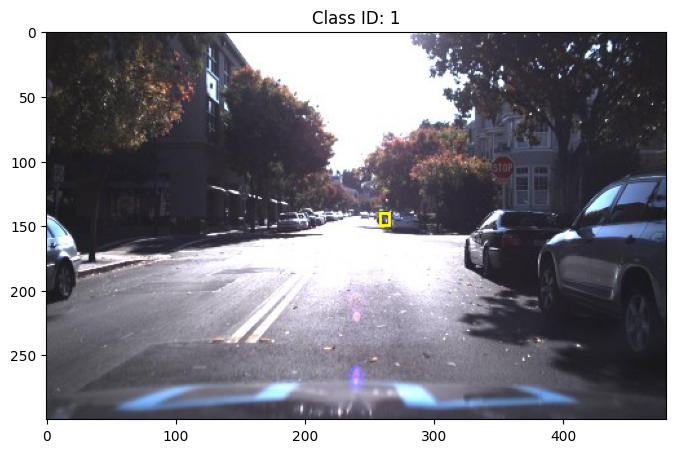

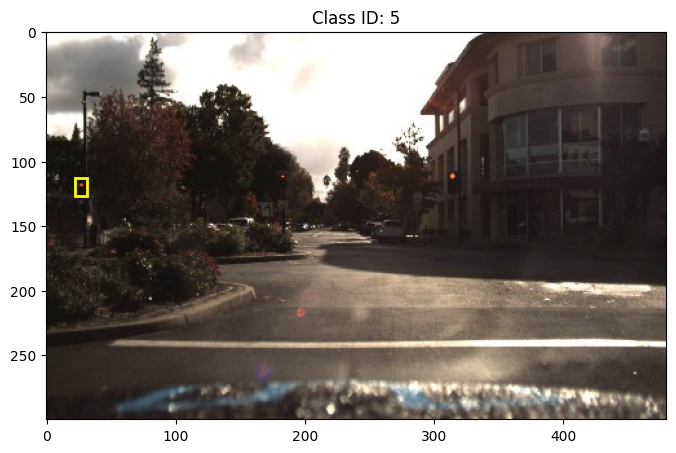

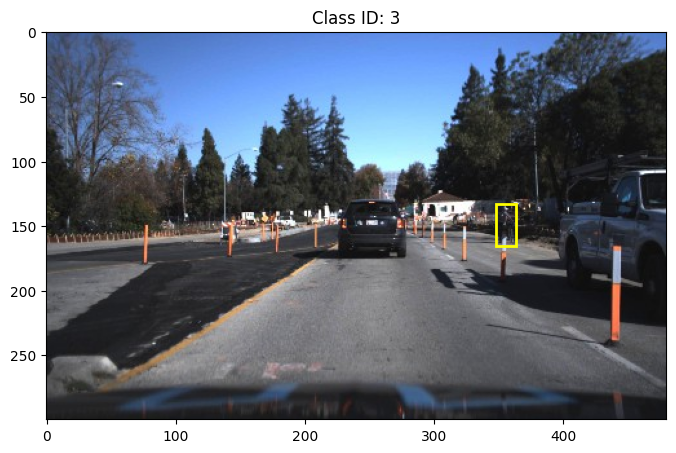

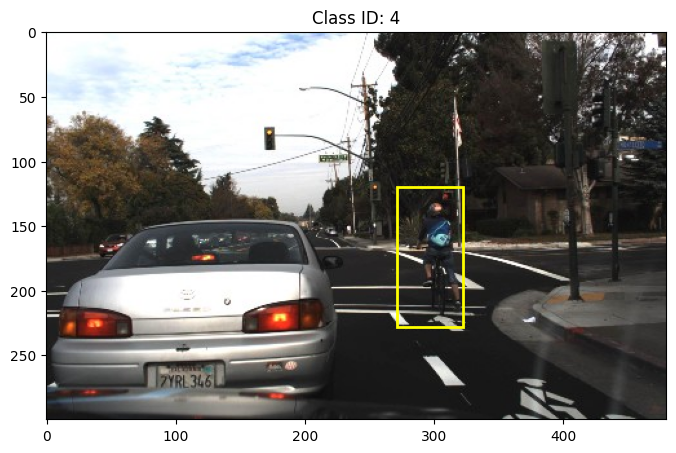

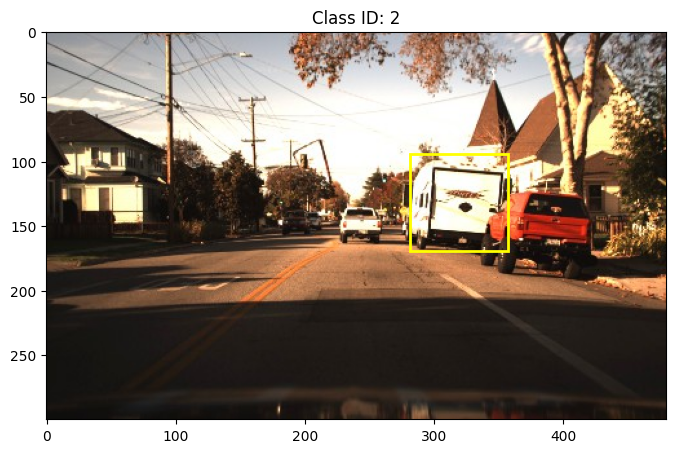

In [5]:
# Load images and bounding boxes
boxes = {}
images = {}
base_path = '/content/drive/MyDrive/498R_Dataset/images/'

for class_id in classes:
    first_row = df[df['class_id'] == class_id].iloc[0]

    # Construct full image path
    image_path = base_path + first_row['frame']

    # Read image and check if it's loaded properly
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image {image_path}")
        continue

    images[class_id] = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
    boxes[class_id] = [first_row['xmin'], first_row['xmax'], first_row['ymin'], first_row['ymax']]

for i in images.keys():  # Iterate over successfully loaded images only
    xmin, xmax, ymin, ymax = boxes[i]

    plt.figure(figsize=(8, 10))
    plt.imshow(images[i])  # Now images are correctly formatted for Matplotlib
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, edgecolor='yellow', fill=False, linewidth=2))
    plt.title(f"Class ID: {i}")
    plt.show()


In [6]:
# Install and import YOLOv8
!pip install ultralytics
from ultralytics import YOLO
from PIL import Image
from IPython.display import display

model = YOLO("yolov8m.pt")


In [7]:
# Model summary
print("YOLOv8 Model Summary:")
print(model.model)

# # Model summary in tabular format
# def model_summary(model):
#     summary_data = []
#     for name, param in model.model.named_parameters():
#         summary_data.append([name, param.shape, param.requires_grad])
#     return pd.DataFrame(summary_data, columns=["Layer Name", "Shape", "Trainable"])

# print("YOLOv8 Model Summary:")
# display(model_summary(model))


YOLOv8 Model Summary:
DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inp

In [8]:
results = model.predict(source='/content/drive/MyDrive/498R_Dataset/images/1478019955679801306.jpg', save=True, conf=0.2, iou=0.5)

for result in results:
    for box in result.boxes:
        class_id = result.names[box.cls[0].item()]
        cords = [round(x) for x in box.xyxy[0].tolist()]
        conf = round(box.conf[0].item(), 2)
        print(f"Object type: {class_id}, Coordinates: {cords}, Probability: {conf}")


WARNING ⚠️ NMS time limit 2.050s exceeded
image 1/1 /content/drive/MyDrive/498R_Dataset/images/1478019955679801306.jpg: 416x640 1 car, 2 buss, 2 trucks, 369.7ms
Speed: 5.0ms preprocess, 369.7ms inference, 2269.7ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs/detect/predict2
Object type: bus, Coordinates: [151, 140, 167, 156], Probability: 0.48
Object type: truck, Coordinates: [423, 110, 480, 160], Probability: 0.3
Object type: car, Coordinates: [187, 146, 197, 152], Probability: 0.27
Object type: bus, Coordinates: [423, 110, 480, 160], Probability: 0.24
Object type: truck, Coordinates: [151, 140, 167, 156], Probability: 0.23


In [9]:
result = results[0]
box = result.boxes[0]

In [10]:
for result in results:
    boxes = result.boxes
    masks = result.masks
    probs = result.probs

In [11]:
results1 = model.predict(source="/content/drive/MyDrive/498R_Dataset/images/1478019960680764792.jpg",
              save=True, conf=0.2,iou=0.5)

Results = results1[0]


image 1/1 /content/drive/MyDrive/498R_Dataset/images/1478019960680764792.jpg: 416x640 3 cars, 42.6ms
Speed: 4.5ms preprocess, 42.6ms inference, 3.4ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs/detect/predict2


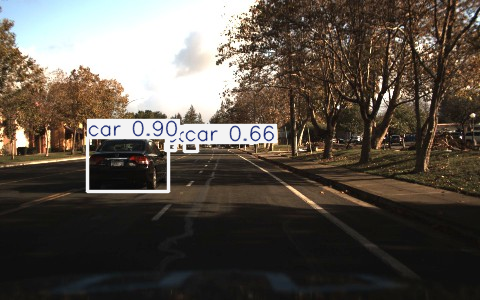

In [12]:
# Plotting results
plot = results1[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
display(Image.fromarray(plot))


image 1/1 /content/drive/MyDrive/498R_Dataset/images/1478019960680764792.jpg: 416x640 3 cars, 27.1ms
Speed: 2.6ms preprocess, 27.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)
Precision: 0.0
Recall: 0.0


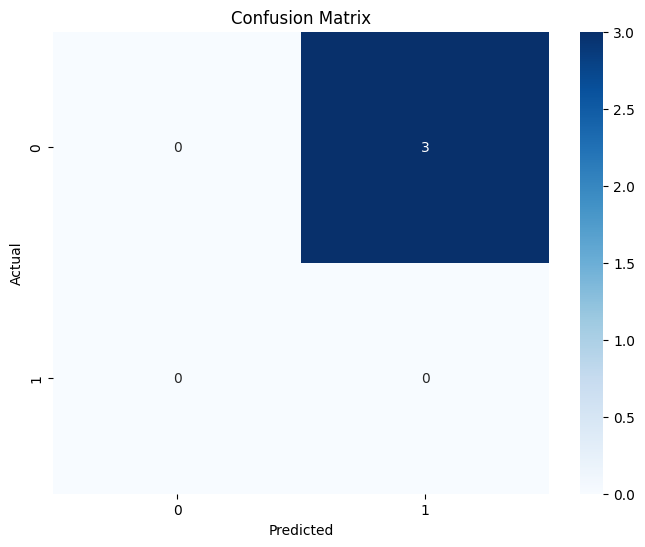

In [13]:
# Precision, Recall, and Confusion Matrix
def evaluate_model(model, test_images, test_labels):
    y_true, y_pred = [], []
    for img, label in zip(test_images, test_labels):
        results = model.predict(img, conf=0.2, iou=0.5)
        for result in results:
            for box in result.boxes:
                y_pred.append(box.cls[0].item())
                y_true.append(label)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    return precision, recall, cm

precision, recall, cm = evaluate_model(model, ['/content/drive/MyDrive/498R_Dataset/images/1478019960680764792.jpg'], [1])
print("Precision:", precision)
print("Recall:", recall)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [29]:
# Install necessary dependencies
!pip install torch torchvision

import torch
from torchvision import models, transforms
from PIL import Image


In [38]:
import torch
from torchvision import models, transforms
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches  # Corrected import

In [39]:
# # Load pre-trained Faster R-CNN model from torchvision
# model_fasterrcnn = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# model_fasterrcnn.eval()  # Set the model to evaluation mode

# # Preprocessing function for Faster R-CNN
# def transform_image(image):
#     transform = transforms.Compose([
#         transforms.ToTensor(),
#     ])
#     return transform(image).unsqueeze(0)

# # Perform inference using Faster R-CNN
# def run_fasterrcnn(image_path):
#     image = Image.open(image_path)
#     image_tensor = transform_image(image)

#     with torch.no_grad():
#         predictions = model_fasterrcnn(image_tensor)

#     return predictions

# # Evaluate model (Precision, Recall, Confusion Matrix)
# def evaluate_fasterrcnn(model, test_images, test_labels):
#     y_true, y_pred = [], []

#     for img_path, label in zip(test_images, test_labels):
#         predictions = run_fasterrcnn(img_path)
#         for element in zip(predictions[0]['boxes'], predictions[0]['labels'], predictions[0]['scores']):
#             box, predicted_label, score = element
#             if score.item() > 0.2:  # Confidence threshold
#                 y_pred.append(predicted_label.item())
#                 y_true.append(label)

#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')
#     cm = confusion_matrix(y_true, y_pred)

#     return precision, recall, cm



# Load pre-trained Faster R-CNN model from torchvision
model_fasterrcnn = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_fasterrcnn.eval()  # Set the model to evaluation mode

# Preprocessing function for Faster R-CNN
def transform_image(image):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    return transform(image).unsqueeze(0)

# Perform inference using Faster R-CNN
def run_fasterrcnn(image_path):
    image = Image.open(image_path)
    image_tensor = transform_image(image)

    with torch.no_grad():
        predictions = model_fasterrcnn(image_tensor)

    return predictions, image

# Function to plot bounding boxes and display results
def plot_results(image, predictions, class_names):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    for element in zip(predictions[0]['boxes'], predictions[0]['labels'], predictions[0]['scores']):
        box, predicted_label, score = element
        if score.item() > 0.2:  # Confidence threshold
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=2, edgecolor='yellow', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(xmin, ymin, f'{class_names[predicted_label.item()]}: {score.item():.2f}', color='yellow', fontsize=12)

    plt.show()

# Evaluate model (Precision, Recall, Confusion Matrix)
def evaluate_fasterrcnn(model, test_images, test_labels, class_names):
    y_true, y_pred = [], []

    for img_path, label in zip(test_images, test_labels):
        predictions, image = run_fasterrcnn(img_path)
        plot_results(image, predictions, class_names)  # Plot bounding boxes

        for element in zip(predictions[0]['boxes'], predictions[0]['labels'], predictions[0]['scores']):
            box, predicted_label, score = element
            if score.item() > 0.2:  # Confidence threshold
                y_pred.append(predicted_label.item())
                y_true.append(label)

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)

    return precision, recall, cm

In [49]:
# # Example test images and labels
# test_images = ['/content/drive/MyDrive/498R_Dataset/images/1478019960680764792.jpg']
# test_labels = [1]  # Actual labels of the images

# # Define the class names (you may need to modify this depending on your dataset)
# class_names = {1: "Class1", 2: "Truck", 3: "Car",4:"Bicycle",5:"Traffic light"}  # Example; replace with your actual class names

# # Evaluate and display results
# precision, recall, cm = evaluate_fasterrcnn(model_fasterrcnn, test_images, test_labels, class_names)
# print("Faster R-CNN Precision:", precision)
# print("Faster R-CNN Recall:", recall)

# # Plot confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Faster R-CNN Confusion Matrix')
# plt.show()

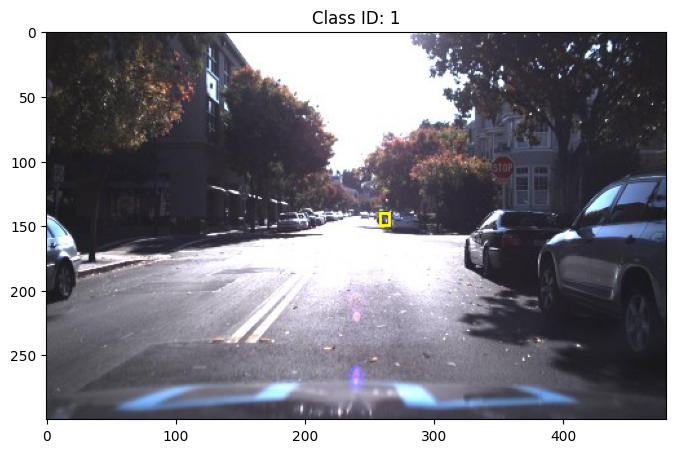

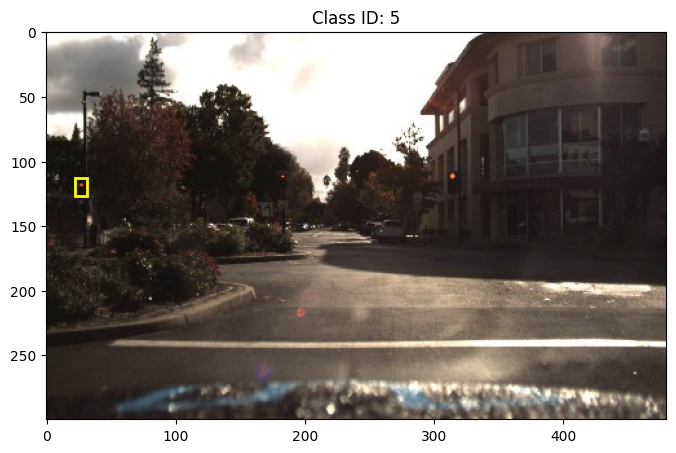

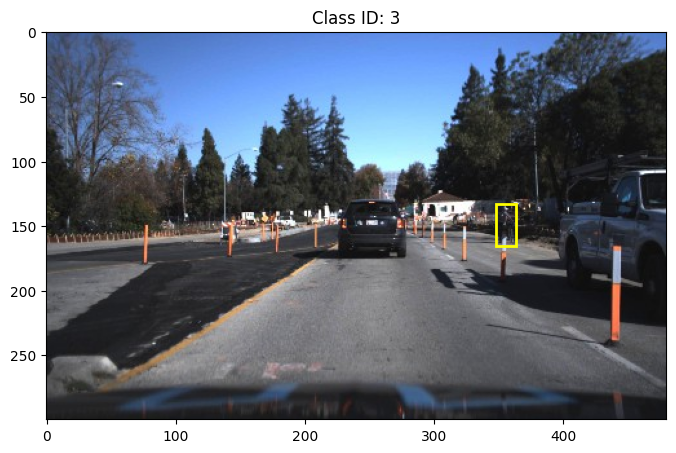

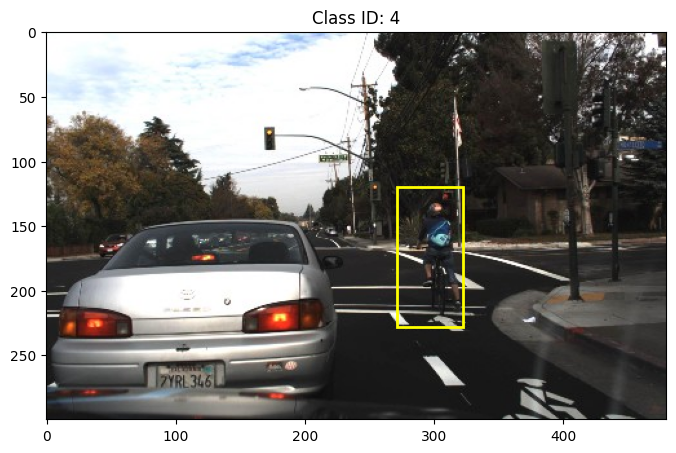

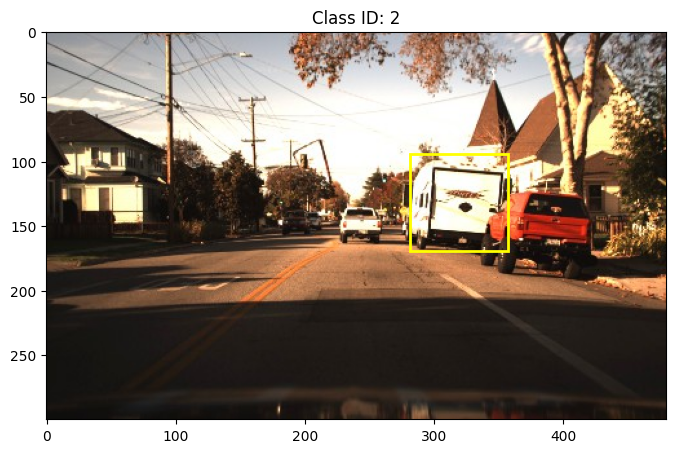

In [50]:
# Load images and bounding boxes
boxes = {}
images = {}
base_path = '/content/drive/MyDrive/498R_Dataset/images/'

for class_id in classes:
    first_row = df[df['class_id'] == class_id].iloc[0]

    # Construct full image path
    image_path = base_path + first_row['frame']

    # Read image and check if it's loaded properly
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image {image_path}")
        continue

    images[class_id] = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
    boxes[class_id] = [first_row['xmin'], first_row['xmax'], first_row['ymin'], first_row['ymax']]

for i in images.keys():  # Iterate over successfully loaded images only
    xmin, xmax, ymin, ymax = boxes[i]

    plt.figure(figsize=(8, 10))
    plt.imshow(images[i])  # Now images are correctly formatted for Matplotlib
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, edgecolor='yellow', fill=False, linewidth=2))
    plt.title(f"Class ID: {i}")
    plt.show()

In [51]:
# Install and import Faster R-CNN
import torchvision
from torchvision import models, transforms

In [52]:
# Load Faster R-CNN pre-trained model
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set model to evaluation mode

# Transformation to convert images to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to process and predict using Faster R-CNN
def predict_with_faster_rcnn(image_path):
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        prediction = model(image_tensor)

    return prediction

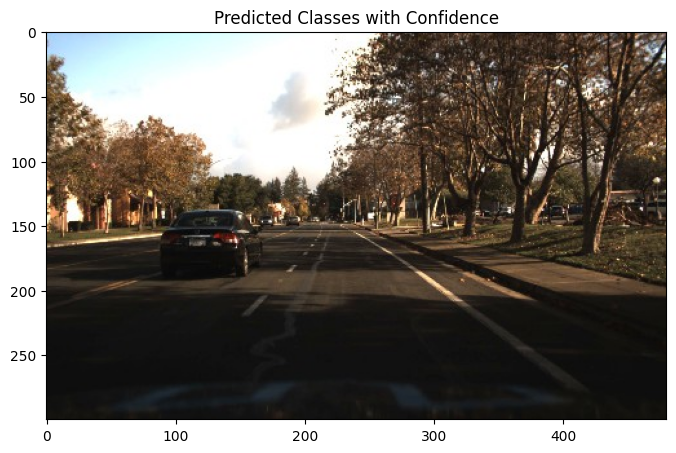

In [58]:
# # Test Faster R-CNN prediction on a single image
# image_path = '/content/drive/MyDrive/498R_Dataset/images/1478019960680764792.jpg'
# prediction = predict_with_faster_rcnn(image_path)

# # Extract bounding boxes and class labels
# boxes = prediction[0]['boxes'].cpu().numpy()
# labels = prediction[0]['labels'].cpu().numpy()
# scores = prediction[0]['scores'].cpu().numpy()

# # Filter predictions based on a confidence threshold
# confidence_threshold = 0.5
# filtered_boxes = boxes[scores >= confidence_threshold]
# filtered_labels = labels[scores >= confidence_threshold]
# filtered_scores = scores[scores >= confidence_threshold]

# # Visualize results
# image = Image.open(image_path)
# plt.figure(figsize=(8, 10))
# plt.imshow(image)
# for box in filtered_boxes:
#     xmin, ymin, xmax, ymax = box
#     plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, edgecolor='yellow', fill=False, linewidth=2))
# plt.title(f"Predicted Classes: {filtered_labels}")
# plt.show()

# Test Faster R-CNN prediction on a single image
image_path = '/content/drive/MyDrive/498R_Dataset/images/1478019960680764792.jpg'
prediction = predict_with_faster_rcnn(image_path)

# Extract bounding boxes, class labels, and scores
boxes = prediction[0]['boxes'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()

# Filter predictions based on a confidence threshold
confidence_threshold = 0.5
filtered_boxes = boxes[scores >= confidence_threshold]
filtered_labels = labels[scores >= confidence_threshold]
filtered_scores = scores[scores >= confidence_threshold]

# Visualize results with bounding boxes, class labels, and confidence score
image = Image.open(image_path)
plt.figure(figsize=(8, 10))
plt.imshow(image)

# Map labels to class names (assuming the class labels are integers, you can map them as needed)
# Example: If your dataset has 'class_id' ranging from 1 to N, you need a map for class IDs to object names.
class_names = {1: "Class1", 2: "Truck", 3: "car"}  # Example class mapping

for box, label, score in zip(filtered_boxes, filtered_labels, filtered_scores):
    xmin, ymin, xmax, ymax = box
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, edgecolor='yellow', fill=False, linewidth=2))

    # Display class name and score on the image
    label_name = class_names.get(label, f"Class {label}")  # Default to 'Class X' if not found
    plt.text(xmin, ymin - 10, f"{label_name} {score:.2f}", color='yellow', fontsize=10, ha='center')

plt.title(f"Predicted Classes with Confidence")
plt.show()


In [57]:
# Function to plot bounding boxes and display results
def plot_results(image, predictions, class_names):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    for element in zip(predictions[0]['boxes'], predictions[0]['labels'], predictions[0]['scores']):
        box, predicted_label, score = element
        if score.item() > 0.2:  # Confidence threshold
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=2, edgecolor='yellow', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(xmin, ymin, f'{class_names[predicted_label.item()]}: {score.item():.2f}', color='yellow', fontsize=12)

    plt.show()

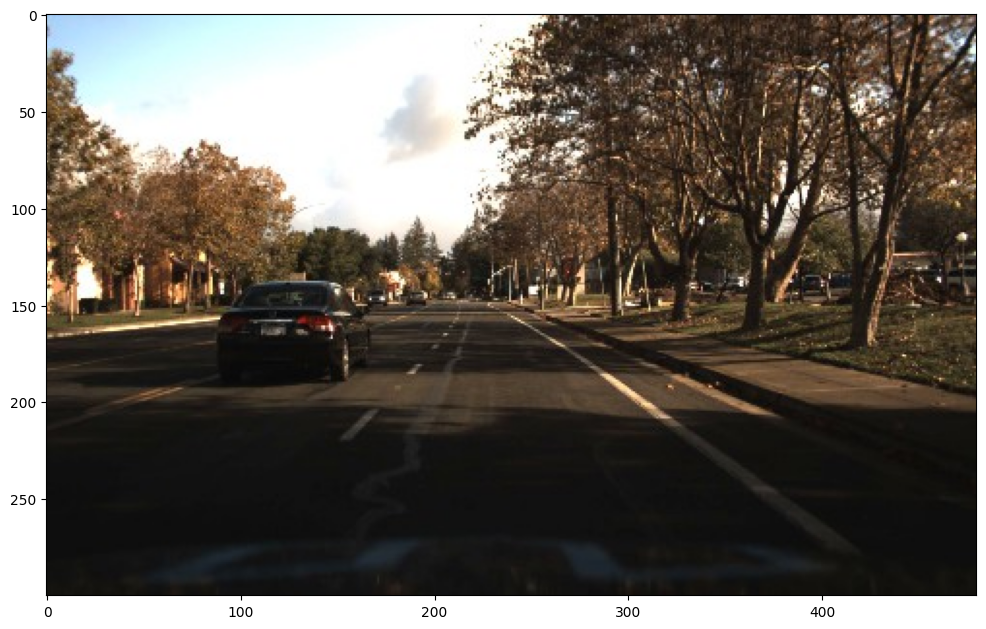

Precision: 0.0
Recall: 0.0


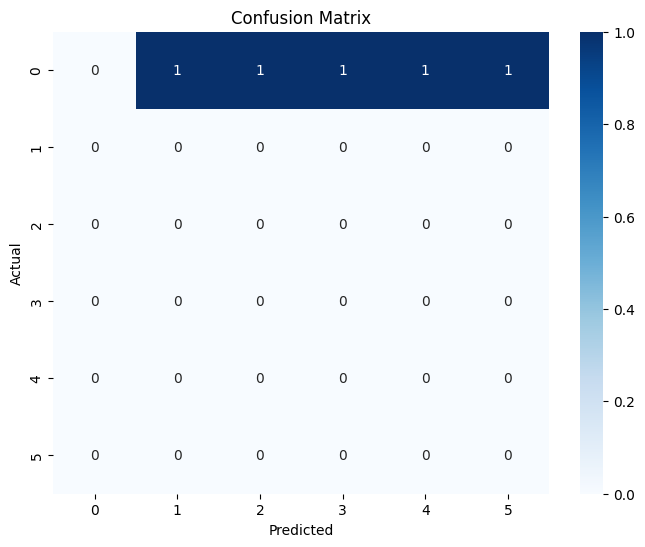

In [60]:
# Precision, Recall, and Confusion Matrix
def evaluate_model(model, test_images, test_labels):
    y_true, y_pred = [], []
    for img, label in zip(test_images, test_labels):
        prediction = predict_with_faster_rcnn(img)
        plot_results(image, prediction, class_names)  # Plot bounding boxes
        boxes = prediction[0]['boxes'].cpu().numpy()
        labels = prediction[0]['labels'].cpu().numpy()

        for predicted_label, box in zip(labels, boxes):
            y_pred.append(predicted_label)
            y_true.append(label)

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    return precision, recall, cm

precision, recall, cm = evaluate_model(model, ['/content/drive/MyDrive/498R_Dataset/images/1478019960680764792.jpg'], [1])
print("Precision:", precision)
print("Recall:", recall)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()